In [23]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.2'

In [ ]:
import numpy as np
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
max_length = 10

results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [ ]:
import string

samples = samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(range(1, len(characters) + 1), characters))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [ ]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(1000,64)

In [ ]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

In [ ]:
import os

imdb_dir = '/home/john/ml/datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indicies = np.arange(data.shape[0])
np.random.shuffle(indicies)
data = data[indicies]
labels = labels[indicies]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
glove_dir = '/home/john/ml/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val,y_val))

In [ ]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [ ]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

In [ ]:
import gc as gc

del history
del model
gc.collect()

In [ ]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
    
final_output_sequence = np.concatenate(successive_outputs, axis=0)

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

In [ ]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history
del model
gc.collect()

In [15]:
import os

data_dir ='/home/john/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [16]:
import numpy as np

float_data = np.zeros((len(lines), len(header) -1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

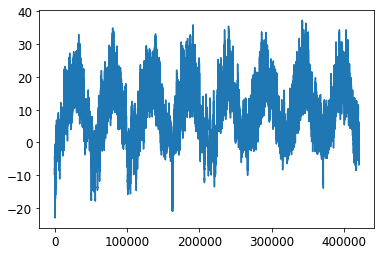

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

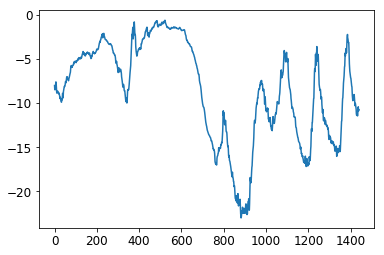

In [18]:
plt.plot(range(1440), temp[:1440])

In [19]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [20]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [21]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile (optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 13s 26ms/step - loss: 1.2049 - val_loss: 0.6596
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 0.4305 - val_loss: 0.3281
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2963 - val_loss: 0.3132
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2681 - val_loss: 0.3065
Epoch 5/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2532 - val_loss: 0.3208
Epoch 6/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2458 - val_loss: 0.3281
Epoch 7/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2384 - val_loss: 0.3157
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2330 - val_loss: 0.3086
Epoch 9/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2293 - val_loss: 0.3164
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.225

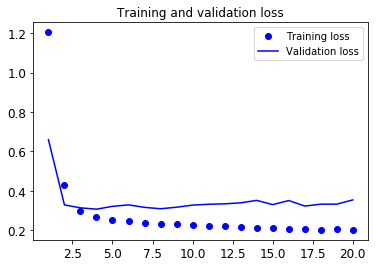

In [14]:
import matplotlib.pyplot as plt

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 211s 422ms/step - loss: 0.2996 - val_loss: 0.2698
Epoch 2/20
500/500 [==============================] - 213s 426ms/step - loss: 0.2838 - val_loss: 0.2668
Epoch 3/20
500/500 [==============================] - 213s 426ms/step - loss: 0.2767 - val_loss: 0.2725
Epoch 4/20
500/500 [==============================] - 225s 449ms/step - loss: 0.2722 - val_loss: 0.2754
Epoch 5/20
500/500 [==============================] - 220s 440ms/step - loss: 0.2686 - val_loss: 0.2636
Epoch 6/20
500/500 [==============================] - 225s 451ms/step - loss: 0.2630 - val_loss: 0.2698
Epoch 7/20
500/500 [==============================] - 218s 436ms/step - loss: 0.2602 - val_loss: 0.2708
Epoch 8/20
500/500 [==============================] - 218s 437ms/step - loss: 0.2565 - val_loss: 0.2756
Epoch 9/20
500/500 [==============================] - 224s 448ms/step - loss: 0.2521 - val_loss: 0.2808
Epoch 10/20
500/500 [==============================] - 208s 417m

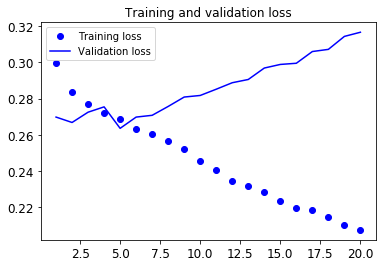

In [16]:
import matplotlib.pyplot as plt

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
del history
del model
gc.collect()

5668

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 244s 488ms/step - loss: 0.3440 - val_loss: 0.2744
Epoch 2/40
500/500 [==============================] - 249s 498ms/step - loss: 0.3128 - val_loss: 0.2726
Epoch 3/40
500/500 [==============================] - 246s 493ms/step - loss: 0.3059 - val_loss: 0.2705
Epoch 4/40
500/500 [==============================] - 243s 485ms/step - loss: 0.3029 - val_loss: 0.2701
Epoch 5/40
500/500 [==============================] - 241s 482ms/step - loss: 0.2992 - val_loss: 0.2693
Epoch 6/40
500/500 [==============================] - 241s 483ms/step - loss: 0.2970 - val_loss: 0.2707
Epoch 7/40
500/500 [==============================] - 241s 482ms/step - loss: 0.2964 - val_loss: 0.2683
Epoch 8/40
500/500 [==============================] - 243s 487ms/step - loss: 0.2916 - val_loss: 0.2740
Epoch 9/40
500/500 [==============================] - 248s 496ms/step - loss: 0.2920 - val_loss: 0.2682
Epoch 10/40
500/500 [==============================] - 255s 509m

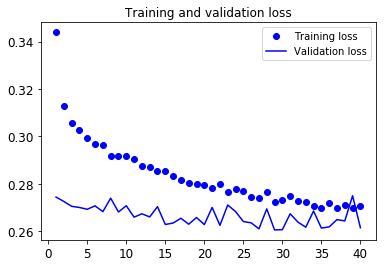

In [19]:
import matplotlib.pyplot as plt

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
del history
del model
gc.collect()

2734

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 496s 992ms/step - loss: 0.3381 - val_loss: 0.2803
Epoch 2/40
500/500 [==============================] - 487s 973ms/step - loss: 0.3130 - val_loss: 0.2831
Epoch 3/40
500/500 [==============================] - 487s 973ms/step - loss: 0.3067 - val_loss: 0.2738
Epoch 4/40
500/500 [==============================] - 487s 973ms/step - loss: 0.2994 - val_loss: 0.2711
Epoch 5/40
500/500 [==============================] - 487s 975ms/step - loss: 0.2971 - val_loss: 0.2739
Epoch 6/40
500/500 [==============================] - 486s 973ms/step - loss: 0.2943 - val_loss: 0.2660
Epoch 7/40
500/500 [==============================] - 487s 974ms/step - loss: 0.2909 - val_loss: 0.2660
Epoch 8/40
500/500 [==============================] - 487s 975ms/step - loss: 0.2864 - val_loss: 0.2677
Epoch 9/40
500/500 [==============================] - 487s 974ms/step - loss: 0.2847 - val_loss: 0.2656
Epoch 10/40
500/500 [==============================] - 488s 976m

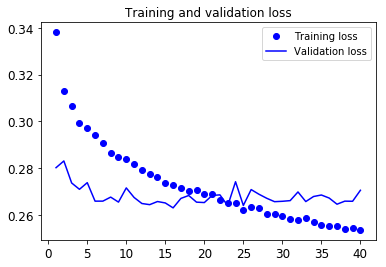

In [25]:
import matplotlib.pyplot as plt

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
del history
del model
gc.collect()

2737

In [27]:
def reverse_order_generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
    
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [28]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 212s 424ms/step - loss: 0.4806 - val_loss: 0.4793
Epoch 2/20
500/500 [==============================] - 211s 422ms/step - loss: 0.4519 - val_loss: 0.4914
Epoch 3/20
500/500 [==============================] - 211s 421ms/step - loss: 0.4149 - val_loss: 0.4652
Epoch 4/20
500/500 [==============================] - 210s 420ms/step - loss: 0.3893 - val_loss: 0.4628
Epoch 5/20
500/500 [==============================] - 211s 422ms/step - loss: 0.3666 - val_loss: 0.4661
Epoch 6/20
500/500 [==============================] - 211s 422ms/step - loss: 0.3451 - val_loss: 0.4623
Epoch 7/20
500/500 [==============================] - 211s 421ms/step - loss: 0.3233 - val_loss: 0.4676
Epoch 8/20
500/500 [==============================] - 211s 422ms/step - loss: 0.3071 - val_loss: 0.4500
Epoch 9/20
500/500 [==============================] - 210s 421ms/step - loss: 0.2928 - val_loss: 0.4717
Epoch 10/20
500/500 [==============================] - 211s 422m

<Figure size 432x288 with 0 Axes>

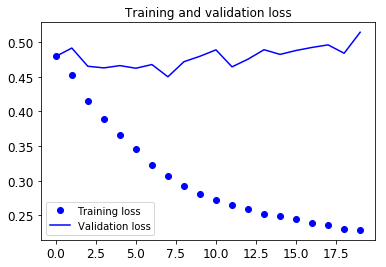

In [29]:
import matplotlib.pyplot as plt

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
del history
del model
gc.collect()

3053

In [32]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model=Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 149s 7ms/step - loss: 0.4922 - acc: 0.7643 - val_loss: 0.6137 - val_acc: 0.7658
Epoch 2/10
20000/20000 [==============================] - 150s 8ms/step - loss: 0.3096 - acc: 0.8835 - val_loss: 0.4358 - val_acc: 0.8360
Epoch 3/10
20000/20000 [==============================] - 150s 8ms/step - loss: 0.2608 - acc: 0.9026 - val_loss: 0.3581 - val_acc: 0.8428
Epoch 4/10
20000/20000 [==============================] - 150s 7ms/step - loss: 0.2207 - acc: 0.9182 - val_loss: 0.3691 - val_acc: 0.8780
Epoch 5/10
20000/20000 [==============================] - 150s 8ms/step - loss: 0.1938 - acc: 0.9324 - val_loss: 0.4741 - val_acc: 0.8262
Epoch 6/10
20000/20000 [==============================] - 140s 7ms/step - loss: 0.1760 - acc: 0.9365 - val_loss: 0.3770 - val_acc: 0.8796
Epoch 7/10
20000/20000 [==============================] - 140s 7ms/step - loss: 0.1600 - acc: 0.9465 - val_loss: 0.5588 - v

In [33]:
from keras import backend as K
K.clear_session()

In [34]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 304s 15ms/step - loss: 0.5573 - acc: 0.7187 - val_loss: 0.4583 - val_acc: 0.7966
Epoch 2/10
20000/20000 [==============================] - 302s 15ms/step - loss: 0.3242 - acc: 0.8756 - val_loss: 0.3377 - val_acc: 0.8838
Epoch 3/10
20000/20000 [==============================] - 305s 15ms/step - loss: 0.2641 - acc: 0.9014 - val_loss: 0.3901 - val_acc: 0.8762
Epoch 4/10
20000/20000 [==============================] - 303s 15ms/step - loss: 0.2315 - acc: 0.9194 - val_loss: 0.3165 - val_acc: 0.8822
Epoch 5/10
20000/20000 [==============================] - 302s 15ms/step - loss: 0.2111 - acc: 0.9247 - val_loss: 0.3255 - val_acc: 0.8860
Epoch 6/10
20000/20000 [==============================] - 305s 15ms/step - loss: 0.1880 - acc: 0.9365 - val_loss: 0.4720 - val_acc: 0.8230
Epoch 7/10
20000/20000 [==============================] - 304s 15ms/step - loss: 0.1690 - acc: 0.9403 - val_loss: 0.3

In [35]:
del history
del model
gc.collect()

4764

In [36]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 433s 867ms/step - loss: 0.2930 - val_loss: 0.2739
Epoch 2/40
500/500 [==============================] - 432s 864ms/step - loss: 0.2743 - val_loss: 0.2708
Epoch 3/40
500/500 [==============================] - 432s 864ms/step - loss: 0.2667 - val_loss: 0.2692
Epoch 4/40
500/500 [==============================] - 427s 854ms/step - loss: 0.2627 - val_loss: 0.2722
Epoch 5/40
500/500 [==============================] - 417s 833ms/step - loss: 0.2554 - val_loss: 0.2720
Epoch 6/40
500/500 [==============================] - 430s 861ms/step - loss: 0.2489 - val_loss: 0.2726
Epoch 7/40
500/500 [==============================] - 430s 861ms/step - loss: 0.2453 - val_loss: 0.2804
Epoch 8/40
500/500 [==============================] - 430s 860ms/step - loss: 0.2399 - val_loss: 0.2831
Epoch 9/40
500/500 [==============================] - 425s 851ms/step - loss: 0.2337 - val_loss: 0.2815
Epoch 10/40
500/500 [==============================] - 421s 843m

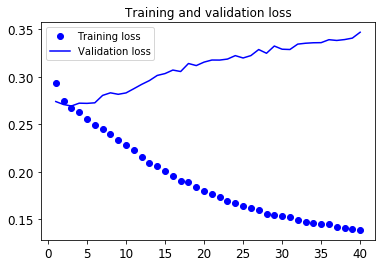

In [37]:
import matplotlib.pyplot as plt

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
del history
del model
gc.collect()

2736

In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [4]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


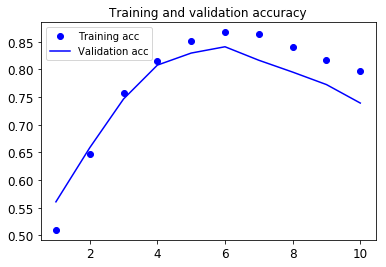

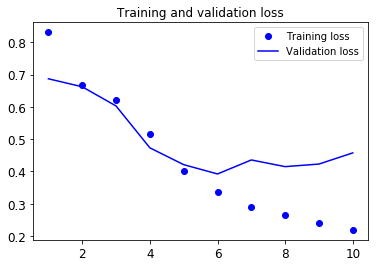

In [5]:
import matplotlib.pyplot as plt

plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 0.4406 - val_loss: 0.4462
Epoch 2/20
500/500 [==================

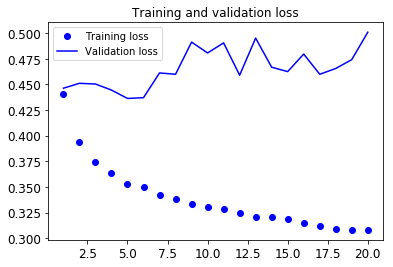

In [25]:
import matplotlib.pyplot as plt

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
del history
del model
gc.collect()

4866

In [27]:
lookback = 1440
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [28]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 179s 359ms/step - loss: 0.3369 - val_loss: 0.2904
Epoch 2/20
500/500 [==============

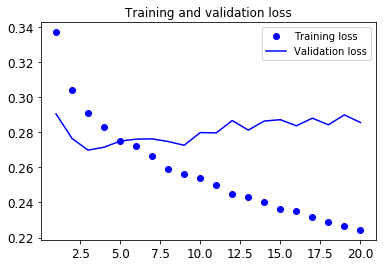

In [29]:
import matplotlib.pyplot as plt

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()